<a href="https://colab.research.google.com/github/thesalmonification/DSCI400_Revamp/blob/master/DuncanDenseNNUsingWavelets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pywt
import tensorflow as tf

Google Colab Import

In [0]:
#Written in Google Collab: add drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read in Pos/Neg Sessions

In [0]:
#Load the pos/emo sessions
PosEmoSessions = list(pd.read_csv('/content/drive/Shared drives/DSCI400_Revamp/PosEmoSessions.csv',header=None)[0])[:200]
NegEmoSessions = list(pd.read_csv('/content/drive/Shared drives/DSCI400_Revamp/NegEmoSessions.csv',header=None)[0])

#print(len(PosEmoSessions))
#print(len(NegEmoSessions))

#Concatenate all pos/neg emo sessions
all_sessions = PosEmoSessions + NegEmoSessions

200
200


Helper Function for determining wavelet coefficients

In [0]:
def Wavelets(waveform_array):
  coeffs = pywt.wavedec(waveform_array, 'db2', level=6) #db2 was nice
  cA6, cD6, cD5,cD4,cD3,cD2,cD1 = coeffs
  cD5 = np.std(cD5)
  cD4 = np.std(cD4)
  cD3 = np.std(cD3)
  cD2 = np.std(cD2)
  cD1 = np.std(cD1)
 
  return [cD5,cD4,cD3,cD2,cD1]


Compute Wavelet Coefficients over all EEG Sessions

In [0]:
##############################################################################
chs = ['Fp1','Fp2','AF3','AF4','F7','F3','Fz','F4','F8','FC5','FC1','FC2','FC6','T7','C3','Cz','C4','T8','CP5','CP1','CP2','CP6','P7','P3','Pz','P4','P8','PO3','PO4','O1','Oz','O2']

to_binary_dict = {'0':0,'4':0,'6':0,'11':0,'1':1,'2':1,'3':1,'5':1,'12':1}




data_pd = pd.read_hdf('/content/drive/Shared drives/DSCI400_Revamp/Waveform_Vocoded_Equalized_Downsampled_Data.h5',key=all_sessions[0])
session_wavelets = []

for ch in chs:
  waveform_array = data_pd[ch].to_numpy()
  waveform_array = np.reshape(waveform_array,(1,6080))
  wavelets = Wavelets(waveform_array)

  session_wavelets = session_wavelets + wavelets
  ########################################################

session_wavelets = np.array(session_wavelets)
factors = np.reshape(session_wavelets,(1,-1))



label_data = pd.read_hdf('/content/drive/Shared drives/DSCI400_Revamp/Label_Data.h5',key=all_sessions[0]+'_labels').T
label_list = [to_binary_dict[label_data['feltEmo'].to_numpy()[0]]]
##############################################################################


for session in all_sessions[1:]:
  #print(session)
  data_pd = pd.read_hdf('/content/drive/Shared drives/DSCI400_Revamp/Waveform_Vocoded_Equalized_Downsampled_Data.h5',key=session)
  label_data = pd.read_hdf('/content/drive/Shared drives/DSCI400_Revamp/Label_Data.h5',key=session+'_labels').T
  feltEmo_val = label_data['feltEmo'].to_numpy()[0]
  label_list = label_list + [to_binary_dict[feltEmo_val]]
  session_wavelets = []

  ########################################################
  for ch in chs:
    waveform_array = data_pd[ch].to_numpy()
    waveform_array = np.reshape(waveform_array,(1,6080))
    wavelets = Wavelets(waveform_array)

    session_wavelets = session_wavelets + wavelets
  ########################################################

  session_wavelets = np.array(session_wavelets)
  session_wavelets = np.reshape(session_wavelets,(1,-1))
    
  factors = np.concatenate((factors,session_wavelets),axis = 0)

#print(factors.shape)
#print(len(label_list))



t276
t2750
t2764
t2758
t2766
t2748
t2744
t2734
t2740
t2746
t2736
t3386
t3396
t34
t3400
t3388
t3398
t3382
t3152
t3146
t3160
t3150
t3156
t3148
t3144
t3142
t394
t3810
t392
t3806
t3802
t3800
t38
t3798
t3782
t3788
t3784
t3786
t3796
t1710
t1708
t1694
t1696
t1700
t1698
t1692
t164
t16
t1730
t1728
t1722
t1718
t1716
t2640
t2634
t270
t268
t2638
t1714
t2632
t2630
t2624
t2620
t2626
t2614
t2608
t2610
t2370
t2368
t2366
t2606
t2364
t2356
t2346
t2350
t2362
t2358
t2344
t2250
t2342
t2242
t2248
t2244
t2240
t2246
t2236
t2232
t2224
t2218
t2214
t2230
t2228
t2222
t2212
t22
t146
t3128
t3132
t3130
t3136
t3026
t3016
t3030
t3020
t3014
t3028
t3022
t3018
t3012
t3676
t3774
t3772
t3776
t3010
t3008
t3678
t3680
t3656
t3660
t3652
t3666
t3650
t3648
t3548
t36
t3642
t3544
t3546
t3550
t528
t526
t530
t534
t540
t414
t424
t420
t412
t416
t418
t422
t410
t4
t948
t404
t402
t40
t406
t950
t946
t942
t932
t928
t938
t936
t930
t926
t818
t922
t916
t816
t136
t14
t802
t812
t1338
t1340
t1334
t1320
t1312
t1322
t132
t1324
t1316
t1310
t8
t796


Model Helper Function

In [0]:
#Make a Keras Model and see what happens...
def KerasModel(lr):
  """
  Paste the Keras Sequential model code here...
  Ensure that you have a learning rate varible "lr" in the optimizer declaration
  """

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Dense(320,input_shape=(160,),activation='relu'))

  model.add(tf.keras.layers.Dense(200))

  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(40))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  #YOUR OPTIMIZER MUST CONTAIN A LEARNING RATE!
  sgd = tf.keras.optimizers.Adam(lr = lr, decay = 1e-5)
  
  
  
  model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])
  #model.summary()

  return model

Do a Test Train Split

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(factors, label_list, test_size=0.33)

#print(X_train.shape)
#print(y_train)

(268, 160)
[1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Test/Train over Multiple Learning Rates: Display Graph for Accuracy vs. Epoch

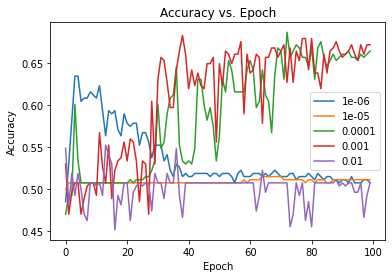

In [0]:
EPOCHS=100
BATCH_SIZE=32


learning_rates = np.power(10*np.ones((5,)),np.array(range(-6,-1))) #10^-6 thru 10^-1


#learning_rates = np.array([.001,.0011,.0012,.0016,.0018])

#learning_rates = np.linspace(.0001,0.01,10)



#Iterate over the learning rates
for lr in learning_rates:
  #Generate model, fit, and plot accuracy over epochs
  model = KerasModel(lr)
  history = model.fit(X_train,np.array(y_train),epochs=EPOCHS,batch_size=BATCH_SIZE, verbose=0)
  plt.plot(history.history['accuracy'])
  
  #Destroy the old model to prevent overloading GPU
  tf.keras.backend.clear_session()

#Plot the graph
plt.legend(learning_rates)
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Do 10-fold Cross Validation: Display Histogram of Cross Validation

In [0]:
#Perform n-fold cross validation
from sklearn.model_selection import KFold


label_array = np.array(label_list)
fold_accuracies = []
n_split=10
 
for train_index,test_index in KFold(n_split,shuffle=True).split(factors):
  x_train,x_test=factors[train_index],factors[test_index]
  y_train,y_test=label_array[train_index],label_array[test_index]


  model = KerasModel(0.001)


  history = model.fit(x_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE, verbose=0)
  test_loss, test_acc = model.evaluate(x_test,y_test)
  fold_accuracies.append(test_acc)
  #plt.figure()
  #plt.stem(model.predict_classes(x_test))
  
  #Destroy the old model to prevent overloading GPU
  tf.keras.backend.clear_session()
  
  
  print("The Number of 1's is:" + str(np.count_nonzero(model.predict_classes(X_test))))
  print("The Number of 0's is:" + str(np.count_nonzero(model.predict_classes(X_test) ==0 )))
  print('-------------------------------------------')

plt.hist(np.array(fold_accuracies) * 100)
plt.title('N-fold Cross Validation: ' + str(int(np.mean(fold_accuracies) * 100)) + '% Avg. Accuracy')
plt.xlabel('Accuracy (%)')
plt.ylabel('Number of Folds')

2/2 [==============================] - 0s 3ms/step - loss: 0.8563 - accuracy: 0.6500
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
The Number of 1's is:62
The Number of 0's is:70
-------------------------------------------
2/2 [==============================] - 0s 2ms/step - loss: 0.6173 - accuracy: 0.7000
The Number of 1's is:100
The Number of 0's is:32
-------------------------------------------
2/2 [==============================] - 0s 3ms/step - loss: 0.7429 - accuracy: 0.5000
The Number of 1's is:68
The Number of 0's is:64
-------------------------------------------
2/2 [==============================] - 0s 2ms/step - loss: 0.5362 - accuracy: 0.8000
The Number of 1's is:78
The Number of 0's is:54
-